# DOG BREED CLASSIFICATION

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install jinja2==3.0.1 --force-reinstall


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached Jinja2-3.0.1-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.2
    Uninstalling MarkupSafe-2.1.2:
      Successfully uninstalled MarkupSafe-2.1.2
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Install pytorch to use as part of the project
!pip install torch #==1.13.1
!pip install torchvision #==0.14.1


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
#%%capture
import torch
import torchvision

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# TODO: Import any packages that you might need - check: more may be required to be added later
# For instance you will need Boto3 and Sagemaker
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
#from torchvision import transforms
import sagemaker
from sagemaker import get_execution_role, image_uris
import boto3
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.model import Model
from PIL import Image

from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter

from jinja2.utils import markupsafe 
from markupsafe import Markup

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.predictor import Predictor


[2023-03-18 15:15:55.412 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:23 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

## Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [6]:
# Specify S3 bucket location for data upload - ToDo: check at what level images are and where for upload
session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

#local_dir = 'dogImages' - comment out upload and only re-run in final re-run of project
bucket = 'sagemaker-us-east-1-308298057408'
prefix = 'data/dogImages'

#train_inputs = session.upload_data('./dogImages/train', bucket=bucket, key_prefix=prefix + '/train')
#valid_inputs = session.upload_data('./dogImages/valid', bucket=bucket, key_prefix=prefix + '/valid')
#test_inputs = session.upload_data('./dogImages/test', bucket=bucket, key_prefix=prefix + '/test')

In [ ]:
## Alternative to using upload_data() method above
#os.environ["DEFAULT_S3_BUCKET"] = bucket
#!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

In [7]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-308298057408/data/dogImages'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-308298057408/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-308298057408/output/'

print(os.environ['SM_CHANNEL_TRAINING'])

s3://sagemaker-us-east-1-308298057408/data/dogImages


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
#TODO: Declare your HP ranges, metrics etc. - change range to a wider range once the code is working
hyperparameters = {'epochs': 5}

hyperparameter_ranges = {
    'lr': ContinuousParameter(0.05,0.1),
    'batch_size': CategoricalParameter([32, 64])
    #,"momentum": ContinuousParameter(0.3, 0.4)
}

objective_metric_name = 'Test Loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'Test Loss', 'Regex': 'Testing Loss: ([0-9\\.]+)'}]

In [13]:
#TODO: Create estimators for your HPs - ToDo: confirm some names: check framework and Python version py36?

estimator = PyTorch(
    entry_point='hpo_AG.py',
    base_job_name='dog-images-hpo',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
    #early_stopping_type='Auto',
)

In [14]:
# TODO: Fit your HP Tuner - check whether wait=True is more appropriate
tuner.fit({"training": "s3://sagemaker-us-east-1-308298057408/data/dogImages/"}, wait=True)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................!


In [16]:
# TODO: Get the best estimators and the best HPs
best_training_job = tuner.best_training_job()
print('The best training job is: {}'.format(best_training_job))

best_estimator = tuner.best_estimator()
print('The best estimator is: {}'.format(best_estimator))

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
print('The best hyperparameters are: {}'.format(best_hyperparameters))

The best training job is: pytorch-training-230318-1546-001-b31f4831

2023-03-18 16:05:04 Starting - Preparing the instances for training
2023-03-18 16:05:04 Downloading - Downloading input data
2023-03-18 16:05:04 Training - Training image download completed. Training in progress.
2023-03-18 16:05:04 Uploading - Uploading generated training model
2023-03-18 16:05:04 Completed - Resource reused by training job: pytorch-training-230318-1546-002-0ebf6600
The best estimator is: <sagemaker.pytorch.estimator.PyTorch object at 0x7f6547782340>
The best hyperparameters are: {'_tuning_objective_metric': '"Test Loss"', 'batch_size': '"64"', 'lr': '0.06531068890084425', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"dog-images-hpo-2023-03-18-15-46-43-860"', 'sagemaker_program': '"hpo_AG.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [17]:
# Add best hyperparameters - ToDo: check what we get - add provisional data to see whether we can get rest of code working
best_estimator = tuner.best_estimator()

best_hyperparameters = {
    'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"','')),
    #'epochs': best_estimator.hyperparameters()['epochs'],
    'lr': best_estimator.hyperparameters()['lr'],
}

print('The best hyperparameters are: {}'.format(best_hyperparameters))


2023-03-18 16:05:04 Starting - Preparing the instances for training
2023-03-18 16:05:04 Downloading - Downloading input data
2023-03-18 16:05:04 Training - Training image download completed. Training in progress.
2023-03-18 16:05:04 Uploading - Uploading generated training model
2023-03-18 16:05:04 Completed - Resource reused by training job: pytorch-training-230318-1546-002-0ebf6600
The best hyperparameters are: {'batch_size': 64, 'lr': '0.06531068890084425'}


In [18]:
# TODO: Set up debugging and profiling rules and hooks: check millis may be shorter (300, 1000)?
rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={'train.save_interval': '1', 'eval_save_interval': '1'}
)

In [19]:
## TODO: Create and fit an estimator: check Python and framework versions
hyperparameters = {'epochs': 5 , 'batch_size': 64, 'lr': 0.06531068890084425}

estimator = PyTorch(
    entry_point='train_model_AG.py',
    base_job_name='dog-images-train',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    framework_version='1.4.0',
    py_version='py3',
)

In [20]:
# Train the model using the best hyperparameters
estimator.fit({"training": "s3://sagemaker-us-east-1-308298057408/data/dogImages/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-images-train-2023-03-18-16-23-25-982


2023-03-18 16:23:27 Starting - Starting the training job...
2023-03-18 16:23:42 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-18 16:24:54 Downloading - Downloading input data
2023-03-18 16:24:54 Training - Downloading the training image.........
2023-03-18 16:26:23 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-18 16:26:14,425 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2023-03-18 16:26:14,453 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-18 16:26:14,455 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-18 16:26:

In [21]:
# Get training job details
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)

print(training_job_name)
#print(description)

dog-images-train-2023-03-18-16-23-25-982


In [22]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-18 16:34:46.236 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:23 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-03-18-16-23-25-982/debug-output


In [23]:
trial.tensor_names()

[2023-03-18 16:34:50.265 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:23 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-03-18 16:34:51.285 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:23 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

#### Use some functions to plot train and eval loss tensors

In [24]:
# Function to get tensor data
def get_data(trial, trname, mode):
    tensor = trial.tensor(trname)
    steps = tensor.steps(mode=mode)
    values = []
    for i in steps:
        values.append(tensor.value(i, mode=mode))
    return steps, values

In [25]:
# Testing - checking output
train_steps, train_values = get_data(trial, 'CrossEntropyLoss_output_0', mode=ModeKeys.TRAIN)
print(train_steps, train_values)

eval_steps, eval_values = get_data(trial, 'CrossEntropyLoss_output_0', mode=ModeKeys.EVAL)
print(train_steps, train_values)

# Print length of training and validation loss function values
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[0] [array(3.041081, dtype=float32)]
[0] [array(3.041081, dtype=float32)]
1
1


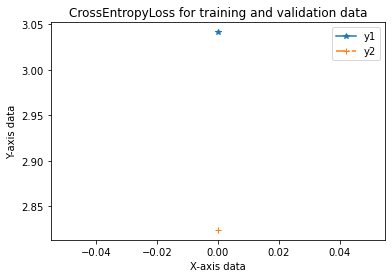

In [26]:
# Plot the 
import matplotlib.pyplot as plt

x = train_steps
y1 = train_values
y2 = eval_values

plt.plot(x, y1, label ='y1', marker='*' )
plt.plot(x, y2, '-.', label ='y2', marker='+')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('CrossEntropyLoss for training and validation data')
plt.show()


- Anomalous behaviour: only one data point each for training and validation data: with current settings there should be 5 each: how can this be remedied? 
- Currently checking in training logs and available output from profiler and debug files


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [27]:
region = "us-east-1"

trainj = TrainingJob(training_job_name, region)
trainj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-308298057408/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-03-18-16-23-25-982/profiler-output


Profiler data from system is available


In [ ]:
system_metric_reader = trainj.get_systems_metrics_reader()
system_metric_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metric_reader,
    framework_metrics_reader=None,
    select_dimensions=['CPU','GPU'],
    select_events=['total'],
)

In [29]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + '/rule_output/'
print(f'The profiler report is located in {rule_output_path}')

The profiler report is located in s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-03-18-16-23-25-982/rule_output/


In [30]:
# List profiler report rule output path
! aws s3 ls {rule_output_path} --recursive

In [31]:
# Copy to local
!aws s3 cp {rule_output_path} ./--resursive

fatal error: An error occurred (404) when calling the HeadObject operation: Key "dog-images-train-2023-03-18-16-23-25-982/rule_output/" does not exist


## Model Deploying

In [34]:
# Use just trained model for deployment - invoking this endpoint failed
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: dog-images-train-2023-03-18-16-38-11-671
INFO:sagemaker:Creating endpoint-config with name dog-images-train-2023-03-18-16-38-11-671
INFO:sagemaker:Creating endpoint with name dog-images-train-2023-03-18-16-38-11-671


--------!

#### Generate endpoint independently of model training

In [43]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-308298057408/dog-images-train-2023-03-18-16-23-25-982/output/model.tar.gz


In [51]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [58]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [59]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-18-17-39-37-782
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-18-17-39-38-520
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-18-17-39-38-520


-----!

In [80]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }
#request_dict={"url": "https://sagemaker-us-east-1-308298057408.s3.amazonaws.com/data/dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00330.jpg"}

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)


bytes

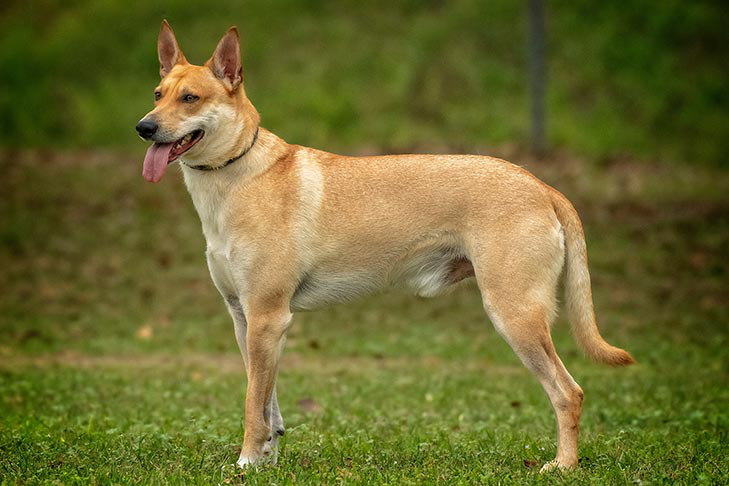

In [81]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [83]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Response received from the primary container has headers with length greater than 4096 bytes. Reduce the length of your container's response headers and update your endpoint.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-03-18-17-39-38-520 in account 308298057408 for more information.

In [ ]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [ ]:
response2[0]

In [ ]:
np.argmax(response, 1)

#### Test using local images

In [84]:
test_path1  = ('./dogImages/test/011.Australian_cattle_dog/Australian_cattle_dog_00730.jpg')
test_path2 = ('./dogImages/test/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08215.jpg')

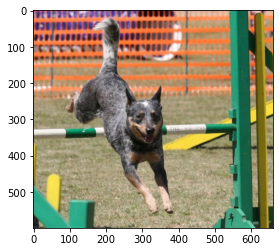

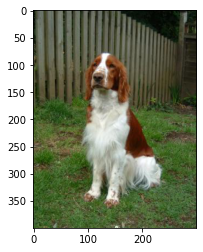

In [85]:
# Testing - showgin local image
test_img1 = plt.imread('./dogImages/test/011.Australian_cattle_dog/Australian_cattle_dog_00730.jpg')

test_img2 = plt.imread('./dogImages/test/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08215.jpg')
plt.imshow(test_img1)
plt.show()
plt.imshow(test_img2)
plt.show()

In [88]:
# Transform images ready to be fed in for inference - this was not applied to images pull in using "requests"
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

pil_image1 = Image.open(test_path1)
pil_image2 = Image.open(test_path2)

test_image1 = image_transform(pil_image1)
test_image2 = image_transform(pil_image2)


In [90]:
type(pil_image1)

PIL.JpegImagePlugin.JpegImageFile

In [91]:
#Generate a prediction for first test image and get the label of first test image
response1 = predictor.predict(pil_image1)

array_data = np.array(response1)
label1 = np.argmax(array_data, axis=1)

print('Dog breed label is: {}'.format(label1+1))

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=660x599 at 0x7F65377D6F10>, type: <class 'PIL.JpegImagePlugin.JpegImageFile'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [ ]:
# Generate a prediction for second test image and get the label of second test image
response2 = predictor.predict(test_image2)

array_data = np.array(response2)
label2 = np.argmax(array_data, axis=1)

print('Dog breed label is: {}'.format(label2+1))

#### Delete Endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done - manual shutdown of endpoint but this cell works as well
predictor.delete_endpoint()